In [5]:
import sys, os
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from modules.licensing import LicensingData
from modules.realestate import RealEstateData
from modules.dynamics import *
from modules.io import read_json, write_json

from matplotlib.lines import Line2D
red_line = Line2D([], [], color='r', lw=3, label='60622')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Read and preprocess raw data

In [ ]:
# read and preprocess licensing data, then save to hdf
# licensing = LicensingData()
# licensing.save()

# Load data

In [2]:
datadir = '../chicago'
property_values_path = os.path.join(datadir, 'realestate.hdf')

# load property values
mvalfah = pd.concat(RealEstateData(property_values_path), axis=1)

In [3]:
datadir = '../chicago'
licensing_data_path = os.path.join(datadir, 'licensing.hdf')

# load licenses and temporarily exclude those outsize zipcodes for which real estate values are unavailable
licenses = LicensingData.load(licensing_data_path)
licenses = licenses[licenses['ZIP CODE'].isin(mvalfah.columns)]

In [4]:
naming = {
    'ID': 'RECORD_ID',
    'LICENSE ID': 'LICENSE_ID',
    'ACCOUNT NUMBER': 'ACCOUNT_ID',
    'SITE NUMBER': 'SITE_ID',
    'LEGAL NAME': 'NAME',
    'DOING BUSINESS AS NAME': 'DBA',
    'ZIP CODE': 'ZIP',
    'LICENSE CODE': 'CODE',
    'LICENSE DESCRIPTION': 'CODE_DESCRIPTION',
    'BUSINESS ACTIVITY ID': 'ACTIVITY_ID',
    'BUSINESS ACTIVITY': 'ACTIVITY',
    'LICENSE NUMBER': 'LICENSE_NUMBER',
    'APPLICATION TYPE': 'APPLICATION_TYPE',
    'LICENSE STATUS': 'STATUS',
    'DATE ISSUED': 'DATE_ISSUED',
    'LICENSE STATUS CHANGE DATE': 'DATE_CHANGED',    
    'LICENSE TERM START DATE': 'DATE_START', 
    'LICENSE TERM EXPIRATION DATE': 'DATE_END',
    'APPLICATION REQUIREMENTS COMPLETE': 'DATE_COMPLETE',
    'PAYMENT DATE': 'DATE_PAID',
    'LICENSE APPROVED FOR ISSUANCE': 'DATE_APPROVED',
    'APPLICATION CREATED DATE': 'DATE_CREATED'
    }
licenses.rename(naming, axis=1, inplace=True)

# exclude record ID (redundant)
licenses.drop('RECORD_ID', axis=1, inplace=True)
licenses.drop('CONDITIONAL APPROVAL', axis=1, inplace=True)

In [5]:
# fix conflicting license number
index = licenses.index[licenses.LICENSE_ID==1237028][0]
licenses.loc[index, 'LICENSE_NUMBER'] = 2022

In [6]:
# split locations into separate database
location_vars = ['NAME', 'DBA', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 
                 'WARD', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT', 
                 'LATITUDE', 'LONGITUDE', 'LOCATION', 'SSA']
locations = licenses.groupby(['ACCOUNT_ID', 'SITE_ID'])[location_vars].first()
locations.sort_index(level=0, inplace=True)
locations.drop(['WARD PRECINCT', 'LOCATION'], axis=1, inplace=True)
licenses.drop(labels=location_vars, axis=1, inplace=True)

In [7]:
# make license ID the new index
licenses.set_index('LICENSE_ID', inplace=True)

In [8]:
# reorder collumns
column_order = ['ACCOUNT_ID', 'SITE_ID', 'LICENSE_NUMBER', 'STATUS', 'APPLICATION_TYPE',
               'CODE', 'CODE_DESCRIPTION', 'ACTIVITY_ID', 'ACTIVITY','DATE_START', 'DATE_END',
                'DATE_CREATED', 'DATE_COMPLETE', 'DATE_PAID', 'DATE_APPROVED', 'DATE_ISSUED' , 'DATE_CHANGED']
licenses = licenses[column_order]

In [9]:
licenses['START'] = licenses.DATE_START

# fill in start dates with issued date (where unavailable)
no_start = licenses[licenses.DATE_START.isnull()].index
licenses.loc[no_start, 'START'] = licenses.loc[no_start, 'DATE_ISSUED']

In [10]:
# store cancellations
cancellations = licenses[licenses.STATUS=='AAC']
revokations = licenses[licenses.STATUS=='REV']

In [15]:
# set license end date
licenses['END'] = licenses.DATE_END

# fix 90 day term length for shared kitchens
short_terms = licenses.ACTIVITY_ID=='805'
licenses.loc[short_terms, 'END'] = licenses.loc[short_terms, 'START'] + pd.Timedelta(value=90, unit='D')

# fix incorrect end date
#error_index = licenses.index[licenses.LICENSE_ID==1300260]
licenses.loc[1300260, 'END'] = licenses.loc[1300260, 'START'] + pd.Timedelta(value=1, unit='Y')

# assign end date to terminated licenses
terminated_ind = licenses.STATUS.isin(['AAC', 'REV'])
licenses.loc[terminated_ind, 'END'] = licenses.loc[terminated_ind, 'DATE_CHANGED']
licenses.loc[terminated_ind, 'START'] = licenses.loc[terminated_ind, 'DATE_CHANGED']

In [16]:
# exclude name/location changes (temporary)
changes = licenses[~licenses.APPLICATION_TYPE.isin(['RENEW', 'ISSUE'])]
licenses = licenses[licenses.APPLICATION_TYPE.isin(['RENEW', 'ISSUE'])]

In [17]:
# exclude licenses whose end date falls before start date
incorrect_dates = (licenses.END - licenses.START) < pd.Timedelta(0)
licenses = licenses[~incorrect_dates]

# exclude licences whose terms ended before 2001
licenses = licenses[licenses.END.apply(lambda x: x.year >= 2001)]

# exclude reapplications/inquiries
licenses = licenses[licenses.STATUS.isin(['AAI', 'AAC', 'REV'])]

In [20]:
# sort by start date
licenses.sort_values(by='START', inplace=True)

In [ ]:
# save to HDF
licenses.to_hdf('../chicago/data/data.hdf', 'licenses', mode='a')
locations.to_hdf('../chicago/data/data.hdf', 'locations', mode='a')
changes.to_hdf('../chicago/data/data.hdf', 'changes', mode='a')
cancellations.to_hdf('../chicago/data/data.hdf', 'cancellations', mode='a')
revokations.to_hdf('../chicago/data/data.hdf', 'revokations', mode='a')

# PARSE INDIVIDUAL LICENSE HISTORIES

In [67]:
from time import time
from modules.licensing import License

In [68]:
"""
PARSE UNIQUE LICENSES
"""

license_history, failed = [], []
for (indices, records) in licenses.groupby(['ACCOUNT_ID', 'LICENSE_NUMBER']):   
    try:
        license_history.append(License(records).aggregate())
    except:
        failed.append(indices)
        
license_history = pd.DataFrame(license_history)

# reindex and set column order
license_history.set_index('LICENSE_NUMBER', inplace=True)
column_order = ['ACCOUNT_ID', 'SITE_ID', 'STATUS', 'START', 'END', 'ORIGINAL', 'CONTINUOUS', 'CODE', 'CODE_DESCRIPTION', 'ACTIVITY', 'ACTIVITY_ID']
license_history = license_history[column_order]

In [117]:
# send active end date to today
license_history.loc[license_history.STATUS == 'ACTIVE', 'END'] = pd.Timestamp.today()
license_history['LIFESPAN'] = license_history.END - license_history.START

In [118]:
# convert activity strings to tuples
license_history['ACTIVITY_ID'] = license_history.ACTIVITY_ID.apply(lambda x: tuple(x.split(' | ')) if type(x) == str else tuple())
license_history['ACTIVITY'] = license_history.ACTIVITY.apply(lambda x: tuple(x.split(' | ')) if type(x) == str else tuple())

In [119]:
# map license codes to descriptions
license_history.CODE = license_history.CODE.astype(str)
codebook = dict(zip(license_history['CODE'].unique(), license_history['CODE_DESCRIPTION'].unique()))

In [121]:
# map activity names to activities
activitybook = {}
for ID, NAME in zip(license_history.ACTIVITY_ID.unique(), license_history.ACTIVITY.unique()):    
    for i, n in zip(ID, NAME):
        activitybook[i] = n

In [124]:
# remove descriptors
license_history.drop(['CODE_DESCRIPTION', 'ACTIVITY'], axis=1, inplace=True)

In [ ]:
# reset index
location_history.set_index(['ACCOUNT_ID', 'SITE_ID'], inplace=True)
location_history.sort_values(by='START', inplace=True)

In [142]:
# save preprocessed data
license_history.to_hdf('../chicago/data/processed.hdf', 'licenses', mode='a')
write_json('../chicago/data/license_codebook.json', codebook)
write_json('../chicago/data/activity_codebook.json', activitybook)

# LOAD PREPROCESSED LICENSE HISTORY

In [7]:
# read preprocessed data (license history)
license_history = pd.read_hdf('../chicago/data/processed.hdf', 'licenses')
codebook = read_json('../chicago/data/license_codebook.json')
activitybook = read_json('../chicago/data/activity_codebook.json')

# AGGREGATE ACROSS INDIVIDUAL LOCATIONS

In [13]:
"""
AGGREGATE INDIVIDUAL LOCATIONS.
"""

from modules.locations import Location

# identify unique locations
location_data = license_history.groupby(['ACCOUNT_ID', 'SITE_ID'])

location_history = []
for index, records in location_data:
    location_history.append(Location(records).aggregate())
location_history = pd.DataFrame(location_history)

# set column order
column_order = ['ACCOUNT_ID', 'SITE_ID', 'ACTIVE', 'START', 'END', 'LIFESPAN', 'ORIGINAL', 'CONTINUOUS', 'NUM_LICENSES', 'ACTIVITIES', 'CODES']
location_history = location_history[column_order]

# set lifespan to days
location_history.LIFESPAN = location_history.LIFESPAN.apply(lambda x: x.days)

# SAVE
location_history.to_hdf('../chicago/data/processed.hdf', 'location_history', mode='a')

# LOAD AGGREGATED LOCATION DATA

In [28]:
# load aggregate location data
location_history = pd.read_hdf('../chicago/data/processed.hdf', 'location_history')
#locations.loc[locations.START.apply(lambda x: x.year<2002), 'ORIGINAL'] = True

In [ ]:
# read locations
locations = pd.read_hdf('../chicago/data/data.hdf', 'locations')

In [140]:
original_locations = locations[locations.ORIGINAL]
new_locations = locations[locations.ORIGINAL==False]

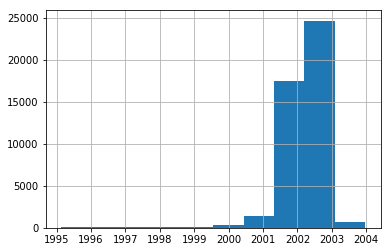

In [141]:
original_locations.START.hist()

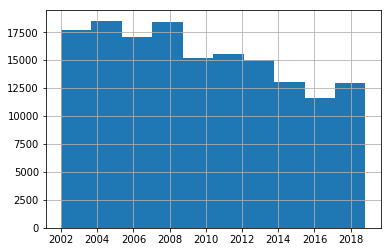

In [142]:
new_locations.START.hist()

In [ ]:
"""
1. group to find those that start each year
2. group to find those that die each year
"""

In [17]:
unique_codes = np.unique(locations.CODES.unique().sum())

In [147]:
mgroup = pd.Grouper(key='START', freq='1M', label='right')
qgroup = pd.Grouper(key='START', freq='3M', label='right')
ygroup = pd.Grouper(key='START', freq='1Y', label='right')

In [92]:
gb = new_locations.groupby(ygroup)

In [98]:
defunct = locations[locations.ACTIVE==False]

In [148]:
ygroup_defunct = pd.Grouper(key='END', freq='1Y', label='right')
defunct.groupby(ygroup_defunct).count()

,ACCOUNT_ID,ACTIVE,ACTIVITIES,ADDRESS,CITY,CODES,CONTINUOUS,DBA,LIFESPAN,NUM_LICENSES,ORIGINAL,SITE_ID,START,ZIP CODE
END,,,,,,,,,,,,,,
1901-12-31,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1902-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1903-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1904-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1905-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1906-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1907-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1908-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1909-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
x = new_locations.START.apply(lambda x: x.year < 2002)

In [125]:
len(new_locations)

155503

In [ ]:
from modules.tables import datframe_to_png

# save table of most common license codes
license_codes = licenses.groupby('LICENSE CODE')['LICENSE DESCRIPTION'].agg(['count', 'first']).sort_values('count', ascending=False)
top10_license_codes = license_codes.iloc[:10]
top10_license_codes.rename({'count': 'NUM. LICENSES', 'first': 'LICENSE TYPE'}, axis=1, inplace=True)
top10_license_codes.reset_index(inplace=True)
top10_license_codes.index = range(1, len(top10_license_codes)+1)
datframe_to_png(top10_license_codes, filename='top10', outputdir='../tables')

<img src="../tables/top10.png" >

# Preprocessing

In [59]:
# identify newly issued licenses
new = licenses[np.logical_and(licenses['APPLICATION TYPE']=='ISSUE', licenses['LICENSE STATUS'] == 'AAI')]
renewed = licenses[np.logical_and(licenses['APPLICATION TYPE']=='RENEW', licenses['LICENSE STATUS'] == 'AAI')]
cancelled = licenses[licenses['LICENSE STATUS'].isin(['AAC', 'REV'])]

# compute number of additions/renewals per zip code
criteria = ['DATE ISSUED', 'ZIP CODE', 'LICENSE CODE']
num_additions = new.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()
num_renewals = renewed.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()
turnover = cancelled.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()

# compute annual additions/renewals per zip code
annual_additions = num_additions.resample('1Y', axis=0).sum()
annual_renewals = num_renewals.resample('1Y', axis=0).sum()
annual_turnover = turnover.resample('1Y', axis=0).sum()

# impute 2011/2012 due to licensing reform
annual_additions = annual_additions.drop(annual_renewals.loc['2011'].index)
annual_additions = annual_additions.drop(annual_renewals.loc['2012'].index)
annual_additions = annual_additions.resample('1Y', axis=0).interpolate()
annual_renewals = annual_renewals.drop(annual_renewals.loc['2011'].index)
annual_renewals = annual_renewals.drop(annual_renewals.loc['2012'].index)
annual_renewals = annual_renewals.resample('1Y', axis=0).interpolate()
annual_turnover = annual_turnover.drop(annual_turnover.loc['2011'].index)
annual_turnover = annual_turnover.drop(annual_turnover.loc['2012'].index)
annual_turnover = annual_turnover.resample('1Y', axis=0).interpolate()

# smooth renewals (some are bi-annual)
annual_renewals = annual_renewals.apply(savgol_filter, args=(3, 1))

/Users/Sebi/.virtualenvs/incubator/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/Users/Sebi/.virtualenvs/incubator/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


# Plot license addition/renewal/turnover timeseries

These are the rates of license additions, renewal, and turnover for each zipcode over the past two decades.

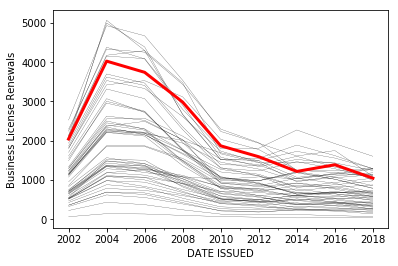

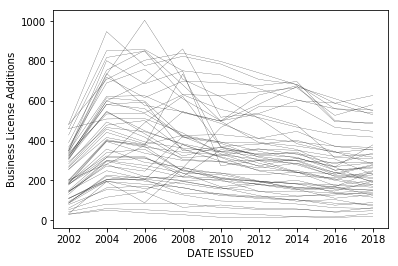

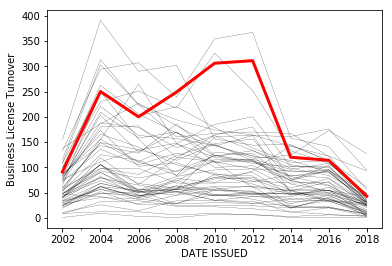

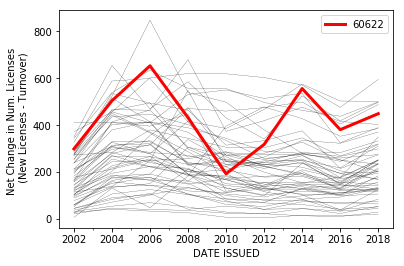

In [61]:
# compute annual additions/renewals per zip code
freq = '2Y'
addition_ts = annual_additions.resample(freq, axis=0).sum()
renewal_ts = annual_renewals.resample(freq, axis=0).sum()
turnover_ts = annual_turnover.resample(freq, axis=0).sum()

# plot license renewals
ax = plot_timeseries(renewal_ts)
ax.set_ylabel('Business License Renewals')
renewal_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license additions
ax = plot_timeseries(addition_ts)
ax.set_ylabel('Business License Additions')
#addition_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')
fig = plt.gcf()
fig.savefig('additions.png')

# plot license turnover
ax = plot_timeseries(turnover_ts)
ax.set_ylabel('Business License Turnover')
turnover_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license growth rate
net_change = (addition_ts-turnover_ts)
ax = plot_timeseries(net_change)
ax.set_ylabel('Net Change in Num. Licenses \n (New Licenses - Turnover)')
ax.set_xlabel('Year')
net_change.loc[:, 60622].plot(ax=ax, lw=3, color='r', label='60622')
ax.legend(handles=[red_line])

# Simple correlation between property values and licensing rates

There is a weak correlation between the annual net change in business licenses and the relative property value.

In [86]:
# normalize and detrend realestate value data
detrended_mvalfah = detrend(normalize_by_baseline(mvalfah, baseline_length=1))

In [87]:
X = net_change
Y = detrended_mvalfah.resample('1Y').mean().loc[X.index, :]
pearsonr(X.values.flatten(), Y.values.flatten())

(0.43210541048175194, 2.415617873086622e-24)